In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import time
import IPython.display as display
import matplotlib.pyplot as plt

In [ ]:
content_path = 'Beach.jpg'
style_path = 'Mountain.jpeg'

In [ ]:
def load_img(path_to_img):
    max_dim = 512
    img = tf.io.read_file(path_to_img)
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    long_dim = max(shape)
    scale = max_dim / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
    img = img[tf.newaxis, :]
    return img

def tensor_to_image(tensor):
    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return tensor

content_image = load_img(content_path)
style_image = load_img(style_path)

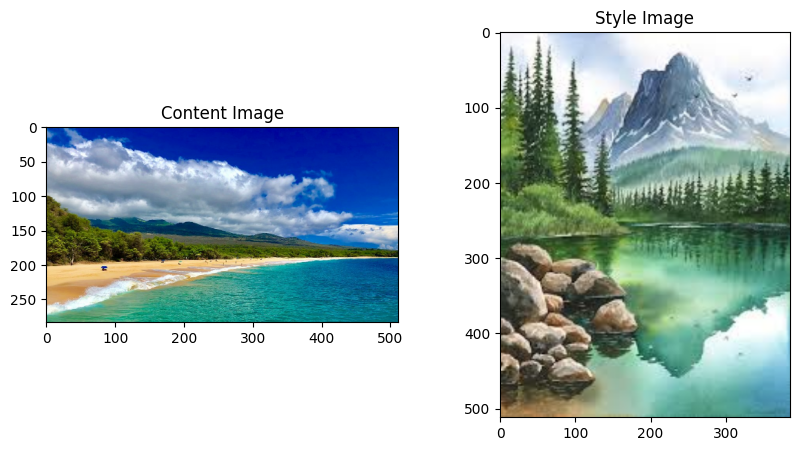

In [ ]:
# Display the original images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(tensor_to_image(content_image))
plt.title('Content Image')
plt.subplot(1, 2, 2)
plt.imshow(tensor_to_image(style_image))
plt.title('Style Image')
plt.show()

In [ ]:
# Step 3: Build the Neural Style Transfer Model
# Use VGG19 pre-trained on ImageNet. Do not include the top classification layers.
vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
vgg.trainable = False

# Select the layers for content and style
content_layers = ['block5_conv2']
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        self.vgg = vgg_layers(style_layers + content_layers)
        self.style_layers = style_layers
        self.content_layers = content_layers
        self.num_style_layers = len(style_layers)
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])
        style_dict = {style_name: value
                      for style_name, value in zip(self.style_layers, style_outputs)}
        content_dict = {content_name: value
                        for content_name, value in zip(self.content_layers, content_outputs)}
        return {'content': content_dict, 'style': style_dict}

def vgg_layers(layer_names):
    """ Creates a VGG model that returns a list of intermediate output values."""
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    vgg.trainable = False
    outputs = [vgg.get_layer(name).output for name in layer_names]
    model = tf.keras.Model([vgg.input], outputs)
    return model

# Step 4: Define the Loss Functions
def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    return result / num_locations

def style_loss(style_outputs, style_targets):
    style_losses = [tf.reduce_mean(tf.square(gram_matrix(output) - gram_matrix(target)))
                    for output, target in zip(style_outputs, style_targets)]
    return tf.add_n(style_losses)

def content_loss(content_outputs, content_targets):
    content_losses = [tf.reduce_mean(tf.square(output - target))
                      for output, target in zip(content_outputs, content_targets)]
    return tf.add_n(content_losses)

In [ ]:
# Step 5: Optimization
extractor = StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image_to_optimize = tf.Variable(content_image)

opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

style_weight = 1e-3
content_weight = 1e5
total_variation_weight = 100

@tf.function()
def train_step(image_to_optimize):
    with tf.GradientTape() as tape:
        model_outputs = extractor(image_to_optimize)
        style_outputs = model_outputs['style']
        content_outputs = model_outputs['content']

        style_w_loss = style_weight * style_loss(style_outputs.values(), style_targets.values())
        content_w_loss = content_weight * content_loss(content_outputs.values(), content_targets.values())
        total_loss = style_w_loss + content_w_loss + total_variation_weight * tf.image.total_variation(image_to_optimize)

    grad = tape.gradient(total_loss, image_to_optimize)
    opt.apply_gradients([(grad, image_to_optimize)])
    image_to_optimize.assign(tf.clip_by_value(image_to_optimize, clip_value_min=0.0, clip_value_max=1.0))


In [ ]:
# Run the optimization loop
start = time.time()
epochs = 10
steps_per_epoch = 100

print("Starting optimization...")
for i in range(epochs):
    for j in range(steps_per_epoch):
        train_step(image_to_optimize)
        if (i * steps_per_epoch + j + 1) % 100 == 0:
            print(f"Step {i * steps_per_epoch + j + 1}/{epochs * steps_per_epoch} complete.")

end = time.time()
print(f"Total time: {end-start}s")

Starting optimization...
Step 100/1000 complete.
Step 200/1000 complete.
Step 300/1000 complete.
Step 400/1000 complete.
Step 500/1000 complete.
Step 600/1000 complete.
Step 700/1000 complete.
Step 800/1000 complete.
Step 900/1000 complete.
Step 1000/1000 complete.
Total time: 57.3877067565918s


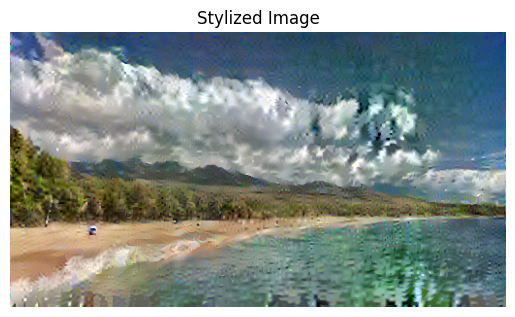

In [ ]:
# Step 6: Save and Display the Result
stylized_image_array = tensor_to_image(image_to_optimize)
plt.imshow(stylized_image_array)
plt.title('Stylized Image')
plt.axis('off')
plt.show()